### Introduction:

This notebook aims to perform a thorough exploratory data analysis (EDA) on the Movies Dataset. After viewing and cleaning the data, various questions are answered including: Finding certain genres, the 5 most expensive movies, the 5 most profitable movies, the most popular movies, movies rated above 7 and the most successful genres. Following this visualisations and discussions are done. First the relationship between revenue and budget is evaluated. Then a study on movie release trends over the years is made. Lastly, we look at the relationship between budget and release years where a comparison of the nominal budget and an inflation adjusted budget is made.

In [ ]:
""" Program to perform exploratory data analysis (EDA) on Movies Dataset.

Load the data.
Clean the data:
  Remove duplicate rows.
  Remove rows with missing data.
  Change data types.
  Change JSON formatting.
Explore the data:
  Find the following:
    Specified genres.
    The 5 most expensive movies.
    The 5 most profitable movies.
    The most popular movies.
    Movies rated above 7.
    The most successful genres.
  Visualisations and discussions:
    Revenue vs. Budget
    Movie release trends over the years
    Budget vs. Year: With comparison of Nominal budget and inflation adjusted
    budget

Functions:
-----
  parse_col_json(column, key):
    Args:
        column: string
            name of the column to be processed.
        key: string
            name of the dictionary key which needs to be extracted
    """

Exploratory data analysis (EDA) is a crucial component of data science which allows you to understand the basics of what your data looks like and what kinds of questions might be answered. For this task, we are going to clean, sanitise and explore our data. Using the movies dataset, complete the steps outlined in this notebook by writing code in the cells.

### Load Data:

In [ ]:
# Import libraries

import numpy as np
import pandas as pd
import seaborn as sns
import ast, json

from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Load the movies dataset
movies_df = pd.read_csv('movies.csv')

### Data Cleansing
#### Clean the data

Identify columns that are redundant or unnecessary. It is always easier to make your decisions based on data which is relevant and concise. Remove the following columns `['homepage', 'keywords', 'original_language', 'original_title', 'overview', 'production_companies', 'status', 'tagline']` from the data set as they will not be used in the analysis.

In [ ]:
# Drop unnecessary columns
movies_df = movies_df.drop(columns=['homepage', 'keywords', 'original_language',
                                    'original_title', 'overview',
                                    'production_companies', 'status', 'tagline']
                           )

#### Remove any duplicate rows

In [ ]:
# Remove duplicate rows
movies_df.drop_duplicates(inplace=True)

#### Remove rows with missing data

Some movies in the database have zero budget or zero revenue which implies that their values have not been recorded or some information is missing. Discard such entries from the dataframe.

In [ ]:
# Remove rows with missing data
movies_df = movies_df.dropna()
# Remove rows with a budget or revenue of 0
movies_df = movies_df[movies_df['budget'] != 0]
movies_df = movies_df[movies_df['revenue'] != 0]

Check budget and revenue values under a certain amount:

In [ ]:
# Count the number of values in budget and revenue less than given amount
amount = 1000
low_budget_count = (movies_df['budget'] < amount).sum()
low_revenue_count = (movies_df['revenue'] < amount).sum()

# Print results
print(f"Number of movies with budgets under ${amount}:", low_budget_count)
print(f"Number of movies with revenues under ${amount}:", low_revenue_count)

Number of movies with budgets under $1000: 13
Number of movies with revenues under $1000: 15


It is possible that some budgets and revenues were recorded incorrectly. We will explore this more when looking at movie budgets.

#### Change data types
To manipulate the columns easily, it is important that we make use of the python objects. Change the release date column into `DateTime` format and extract the year from the date. This will help us in analysing yearly data.

In [ ]:
# Change the release_date column to DateTime
movies_df['release_date'] = pd.to_datetime(movies_df['release_date'], errors='coerce')

# Extract the release year from every release date
movies_df['year'] = movies_df['release_date'].dt.year

Change budget and revenue columns to a integer data type using numpy’s `int64` method.

In [ ]:
# Change budget and revenue columns to a integer data type
movies_df['budget'] = pd.to_numeric(movies_df['budget'], errors='coerce').astype(np.int64)
movies_df['revenue'] = pd.to_numeric(movies_df['revenue'], errors='coerce').astype(np.int64)

#### Change JSON formatting

On checking the dataset, we see that `genres`, `production_countries`, `spoken_languages` are in the JSON format which will make it difficult to manipulate the dataframe. The `parse_col_json function` flattens these columns into a format that can be easily interpreted.

In [ ]:
# Convert from JSON format to a list of strings
def parse_col_json(column, key):
    """
    Args:
        column: string
            name of the column to be processed.
        key: string
            name of the dictionary key which needs to be extracted
    """
    for index,i in zip(movies_df.index, movies_df[column].apply(json.loads)):
        list1=[]
        for j in range(len(i)):
            list1.append((i[j][key]))# the key 'name' contains the name of the genre
        movies_df.loc[index, column] = str(list1)

# Flatten data in columns
parse_col_json('genres', 'name')
parse_col_json('production_countries', 'name')
parse_col_json('spoken_languages', 'name')


In [ ]:
# Inspect flattened data
movies_df.sample(1)

,budget,genres,id,popularity,production_countries,release_date,revenue,runtime,spoken_languages,title,vote_average,vote_count,year
2533,17000000,"['Drama', 'Horror', 'Thriller']",65086,43.675191,"['Canada', 'Sweden', 'United Kingdom']",2012-02-01,127730736,95.0,['English'],The Woman in Black,6.1,1206,2012


### Finding Certain Genres
Locate all movies in the "Action" genre.

In [ ]:
# Create a dataframe with all the movies in the "Action" genre

# Wanted genre
genre_check = 'action'
# Convert the 'genres' column to lowercase
movies_df['genres'] = movies_df['genres'].str.lower()
# Check if genre is present in the 'genres' column for each movie
action_movies = movies_df[movies_df['genres'].str.contains(genre_check)]
# Print the action movie titles
print(f"{genre_check} movies list:\n")
print(action_movies['title'])
print(f"\nTotal Number of {genre_check} movies: {action_movies.shape[0]}")

action movies list:

0                                         Avatar
1       Pirates of the Caribbean: At World's End
2                                        Spectre
3                          The Dark Knight Rises
4                                    John Carter
                          ...                   
4664                                     Bronson
4670                                     Mad Max
4701           Sweet Sweetback's Baadasssss Song
4772                                Down Terrace
4798                                 El Mariachi
Name: title, Length: 918, dtype: object

Total Number of action movies: 918


### Now onto the exploration

#### Identify relationships between variables (features)

The main goal here is to identify and create relationships that can help you formulate ideas. We have defined questions to help you identify some relationships to explore.

#### Which are the 5 most expensive movies?

How do the most expensive and cheapest movies compare? Exploring the most expensive movies highlights if some movies are worth the money spent on them based on their performance and revenue generated.

In [ ]:
# Sort the DataFrame by 'budget'
# In descending order for most expensive and ascending for cheapest
most_expensive_movies = movies_df.sort_values(by='budget', ascending=False)
cheapest_movies = movies_df.sort_values(by='budget', ascending=True)

# Print the 5 most expensive movies
print("Top 5 Most Expensive Movies:")
print(most_expensive_movies[['title', 'budget', 'revenue', 'year']].head(5))

# Print the cheapest movies
print("\nCheapest Movies:")
print(cheapest_movies[['title', 'budget', 'revenue', 'year']].head(30))

Top 5 Most Expensive Movies:
                                          title     budget     revenue  year
17  Pirates of the Caribbean: On Stranger Tides  380000000  1045713802  2011
1      Pirates of the Caribbean: At World's End  300000000   961000000  2007
7                       Avengers: Age of Ultron  280000000  1405403694  2015
10                             Superman Returns  270000000   391081192  2006
4                                   John Carter  260000000   284139100  2012

Cheapest Movies:
                             title  budget    revenue  year
4238                  Modern Times       1    8500000  1936
3611            A Farewell to Arms       4         25  1932
3372                  Split Second       7          5  1992
3419                  Bran Nue Dae       7          7  2009
4608                  The Prophecy       8         16  1995
3131             Of Horses and Men      10         11  2013
3137                     Nurse 3-D      10   10000000  2013
2933       

It appears that some of the budgets and revenues have been entered incorrectly. A Google search of a few of the movies shows that the zeros are missing from many of these values. The missing zeroes are, however, not consistent. For example, the budget of 'Modern Times' should be \$1.5 million. The entry for this is given as \$1 meaning 6 zeroes are missing from the entry. Whereas for 'Eraserhead' the budget should be \$100 000. The entry for this is given as \$10 000, meaning only one zero is missing. There are a few outliers, however, that are accurate, such as 'Tarnation'. It is difficult to correct all of this data with so many varying errors. We will, therefore, ignore the 20 cheapest films, after which the data appears to be more accurate, and compare the most expensive films to the cheapest films excluding the 20 'cheapest' entries.

To visualise the varying budgets better, we can plot a histogram of the logarithm of the budgets to see the trend.

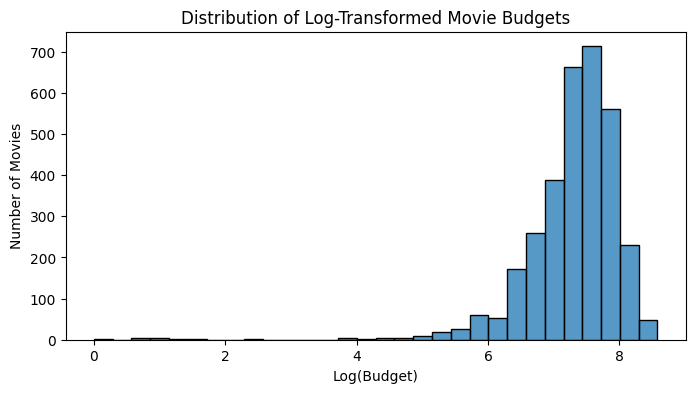

In [ ]:
# Get logarithm of the 'budget' column
movies_df['log_budget'] = np.log10(movies_df['budget'])
# Create a histogram of log-transformed movie budgets
plt.figure(figsize=(8, 4))
sns.histplot(x='log_budget', data=movies_df, bins=30)
plt.title('Distribution of Log-Transformed Movie Budgets')
plt.xlabel('Log(Budget)')
plt.ylabel('Number of Movies')
plt.show()

From this histogram we see the many outliers in the lower budgets. Some of these outliers may be accurate but the majority are probably inaccurate entries. Starting from a budget of ~\$10 000 eliminates most of these errors.

In [ ]:
cheapest_movies = cheapest_movies.iloc[20:]

# Print the 5 most expensive movies
print("Top 5 Most Expensive Movies:")
print(most_expensive_movies[['title', 'budget', 'revenue', 'year', 'popularity', 'vote_average']].head(5))

# Print the cheapest movies
print("\nCheapest Movies:")
print(cheapest_movies[['title', 'budget', 'revenue', 'year', 'popularity', 'vote_average']].head(5))

Top 5 Most Expensive Movies:
                                          title     budget     revenue  year  \
17  Pirates of the Caribbean: On Stranger Tides  380000000  1045713802  2011   
1      Pirates of the Caribbean: At World's End  300000000   961000000  2007   
7                       Avengers: Age of Ultron  280000000  1405403694  2015   
10                             Superman Returns  270000000   391081192  2006   
4                                   John Carter  260000000   284139100  2012   

    popularity  vote_average  
17  135.413856           6.4  
1   139.082615           6.9  
7   134.279229           7.3  
10   57.925623           5.4  
4    43.926995           6.1  

Cheapest Movies:
                        title  budget    revenue  year  popularity  \
4772             Down Terrace   31192      10000  2009    1.330379   
4496  The Blair Witch Project   60000  248000000  1999   41.690578   
4738                       Pi   60000    3221152  1998   27.788067   
4752  

It seems, in terms of popularity, the higher budget films are more popular. However, the vote average for the highest and lowest budgets does not differ much.

#### What are the top 5 most profitable movies?

Compare the min and max profits. The comparison helps us identify the different approaches which failed and succeeded. Subtracting the budget from the revenue generated, will return the profit earned.

In [ ]:
# Calculate the profit for each movie
movies_df['profit'] = movies_df['revenue'] - movies_df['budget']

# Arrange the DataFrame by profit in descending order
movies_sorted_profit = movies_df.sort_values(by='profit', ascending=False)

# Get the top and bottom entries based on profit
top_profit_movies = movies_sorted_profit.head(5)
bottom_profit_movies = movies_sorted_profit.tail(5)

# Print results
print("Top Profit Movies:")
print(top_profit_movies[['title', 'profit']])

print("\nBottom Profit Movies:")
print(bottom_profit_movies[['title', 'profit']])

Top Profit Movies:
             title      profit
0           Avatar  2550965087
25         Titanic  1645034188
28  Jurassic World  1363528810
44       Furious 7  1316249360
16    The Avengers  1299557910

Bottom Profit Movies:
                            title     profit
311  The Adventures of Pluto Nash  -92896027
208              The 13th Warrior  -98301101
141               Mars Needs Moms -111007242
338                     The Alamo -119180039
13                The Lone Ranger -165710090


#### Find the most popular movies.
Sort the dataframe based on the popularity column.

In [ ]:
# Arrange the DataFrame by popularity in descending order
movies_sorted_popularity = movies_df.sort_values(by='popularity', ascending=False)

# Get the most popular movies
most_popular_movies = movies_sorted_popularity.head(5)

# Print results
print("Most popular Movies:")
print(most_popular_movies[['title', 'popularity']])

Most popular Movies:
                       title  popularity
546                  Minions  875.581305
95              Interstellar  724.247784
788                 Deadpool  514.569956
94   Guardians of the Galaxy  481.098624
127       Mad Max: Fury Road  434.278564


#### Find Movies which are rated above 7

In [ ]:
# Get movies rated above 7
high_rated_movies = movies_df[movies_df['vote_average'] > 7]
high_rated_movies = high_rated_movies.sort_values(by='vote_average', ascending=False)

# Print result
print("Movies Rated Above 7:")
print(high_rated_movies[['title', 'vote_average']])
print("\nTotal movies rated above 7: ", high_rated_movies.shape[0])

Movies Rated Above 7:
                                   title  vote_average
1881            The Shawshank Redemption           8.5
2970                  There Goes My Baby           8.5
3337                       The Godfather           8.4
1818                    Schindler's List           8.3
3232                        Pulp Fiction           8.3
...                                  ...           ...
978   The Life Aquatic with Steve Zissou           7.1
1745                  My Sister's Keeper           7.1
3436                       The Messenger           7.1
1720                            Kick-Ass           7.1
2797              Lars and the Real Girl           7.1

[637 rows x 2 columns]

Total movies rated above 7:  637


#### Most successful genres
Create a bar plot explaining the frequency of movies in each genre.

<ipython-input-109-a8fed63060c8>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  genres_list = movies_df['genres'].str.replace('[\[\]\'\"]', '').str.split(',')
<ipython-input-109-a8fed63060c8>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genres_counts.index, y=genres_counts.values, palette="viridis")


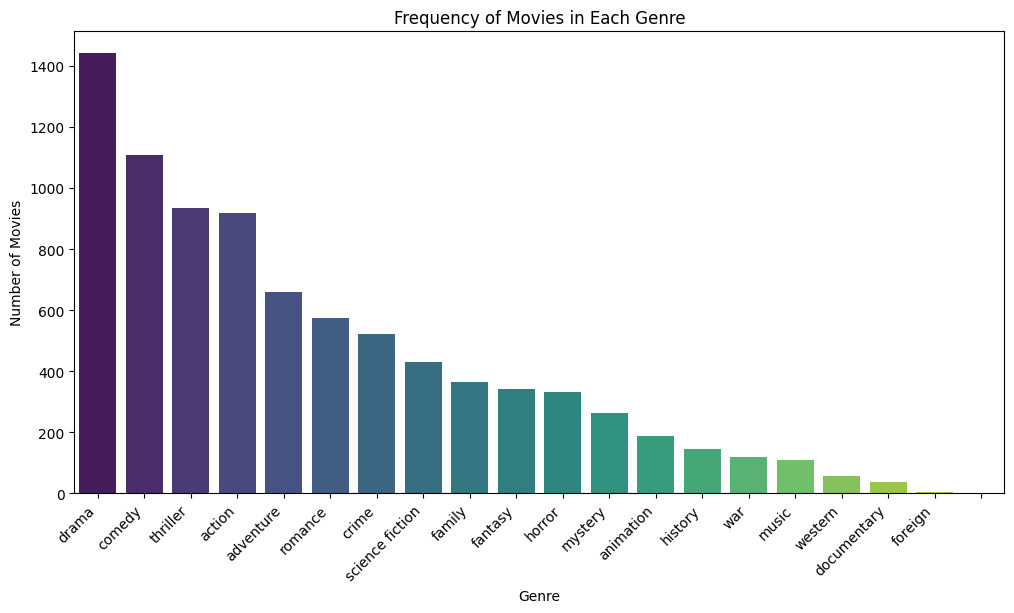

In [ ]:
# Split the genres column into a list of genres and strip characters
genres_list = movies_df['genres'].str.replace('[\[\]\'\"]', '').str.split(',')

# Drop rows where the 'genres' column is NaN or missing
genres_list = genres_list.dropna()

# Create a flat list of all genres, strip spaces
all_genres = [genre.strip() for sublist in genres_list for genre in sublist]

# Create a DataFrame with the counts of each genre
genres_counts = pd.Series(all_genres).value_counts()

# Create bar plot of genre frequencies
plt.figure(figsize=(12, 6))
sns.barplot(x=genres_counts.index, y=genres_counts.values, palette="viridis")
plt.title('Frequency of Movies in Each Genre')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability
plt.show()

The genre that occurs most frequently is 'drama', followed by 'comedy' and 'thriller'. The genre that occurs the least is 'foreign', followed by 'documentary' and 'western'.

In [ ]:
# Generate three different interesting visualisations with a data story.

### **Revenue vs. Budget Scatter Plot**

<ipython-input-111-3533021ed141>:7: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=movies_df, x='log_budget', y='log_revenue', alpha=0.7, palette='viridis')


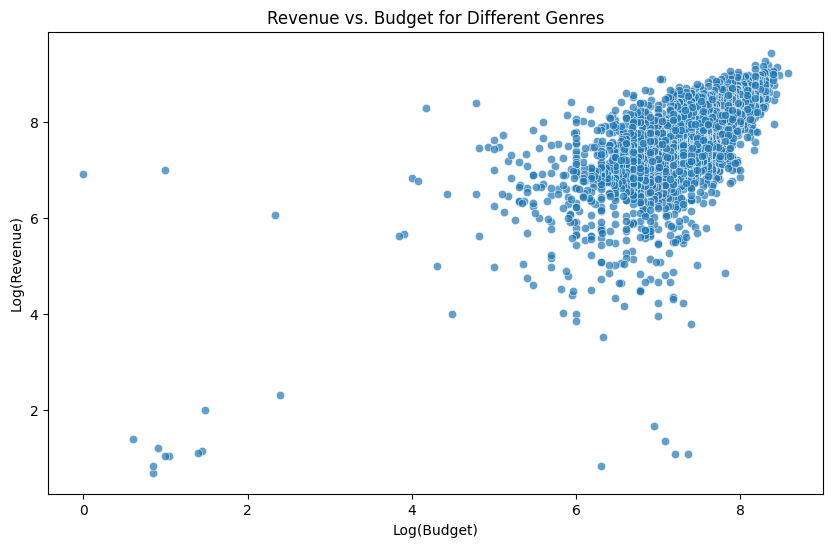

In [ ]:
# Get logarithm of the 'budget' column
movies_df['log_revenue'] = np.log10(movies_df['revenue'])


# Plotting a scatter plot of revenue vs. budget in the log scale
plt.figure(figsize=(10, 6))
sns.scatterplot(data=movies_df, x='log_budget', y='log_revenue', alpha=0.7, palette='viridis')
plt.title('Revenue vs. Budget for Different Genres')
plt.xlabel('Log(Budget)')
plt.ylabel('Log(Revenue)')
#plt.legend(title='Genres', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

This scatter plot shows the relationship between movie budgets and revenues. It helps us identify trends and patterns in the money that goes in to making movies, such as the fact that there is a general positive correlation between the budget and revenue. This is particularly evident for the higher values where higher-budget movies tend to generate more revenue.

### **Movie release trends over the years:**

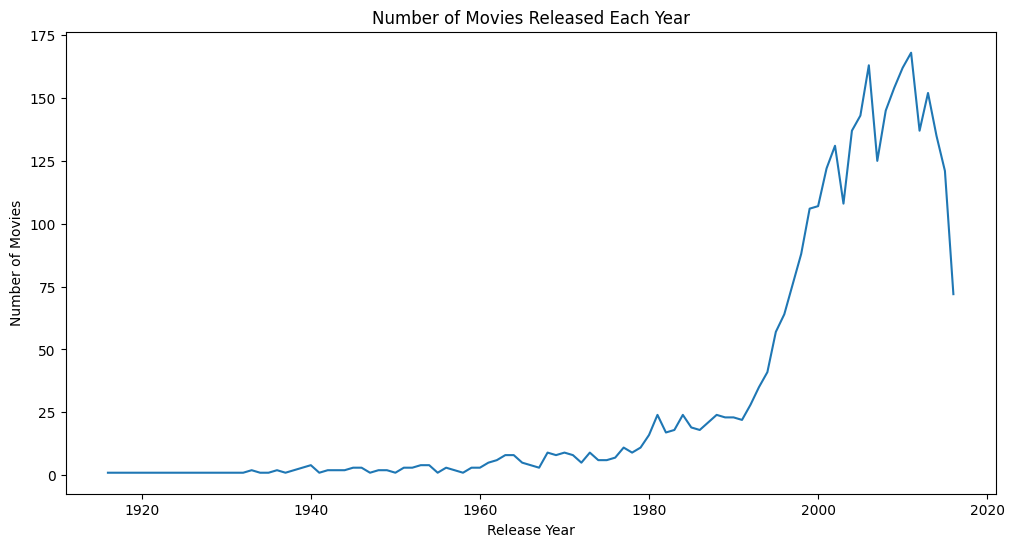

In [ ]:
# Plotting a line chart for the number of movies released each year
plt.figure(figsize=(12, 6))
sns.lineplot(data=movies_df.groupby('year').size())
plt.title('Number of Movies Released Each Year')
plt.xlabel('Release Year')
plt.ylabel('Number of Movies')
plt.show()

This line chart illustrates the trends in the number of movies released each year. It provides insights into the growth or decline in the film industry over time. We can see how few movies were released from around 1920 when the movie industry was in its early stages of development. There is a slow increase up to around 1990, from where the number of movies released increases dramatically. This could have been due to the rise of blockbuster films, greater international collaboration, and from new distribution channels, such as home video and cable television. Interestingly, the movie production reaches its peak at around 2010 where it falls rapidly again. This may have been a result of increased competition from other forms of entertainment, such as streaming services, and an increase in popularity and preference for television series as opposed to movies.

###**Budget vs Year: Nominal Budget vs Inflation Adjusted Budget**

Let us look at how the movie budgets change thorughout the years. We expect movie budgets to increase with time but if we adjust for inflation, do the budgets still increase?

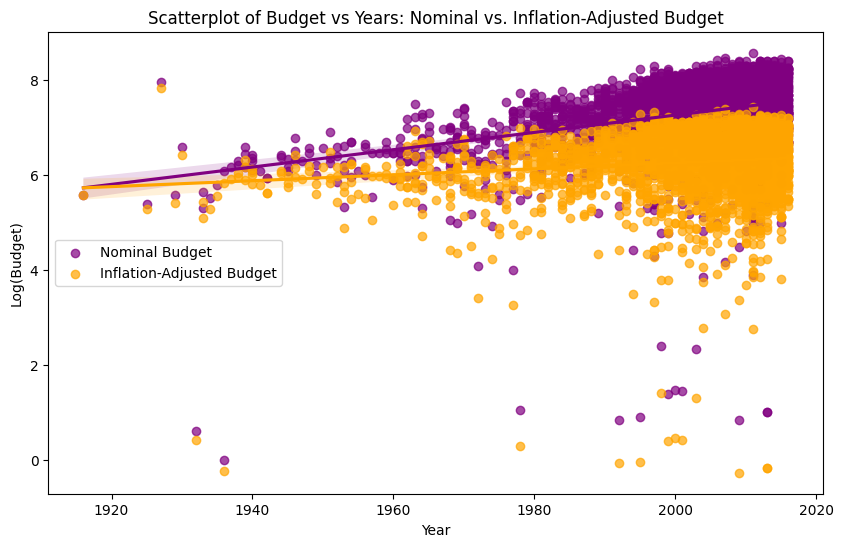

In [ ]:
# Calculate inflation-adjusted budget using a 2.8% annual inflation rate
inflation_rate = 0.028
movies_df['inflation_adjusted_budget'] = movies_df['budget'] / (1 + inflation_rate) ** (movies_df['year'] - movies_df['year'].min())

# Get logarithm of the inflation-adjusted budget
movies_df['log_inflation_adjusted_budget'] = np.log10(movies_df['inflation_adjusted_budget'])

# Plotting the scatter plot with both regression lines
plt.figure(figsize=(10, 6))

# Nominal Budget
sns.regplot(data=movies_df, x='year', y='log_budget', color='purple', scatter_kws={'alpha': 0.7}, label='Nominal Budget')

# Inflation-Adjusted Budget
sns.regplot(data=movies_df, x='year', y='log_inflation_adjusted_budget', color='orange', scatter_kws={'alpha': 0.7}, label='Inflation-Adjusted Budget')

plt.title('Scatterplot of Budget vs Years: Nominal vs. Inflation-Adjusted Budget')
plt.xlabel('Year')
plt.ylabel('Log(Budget)')
plt.legend()
plt.show()

When examining the nominal budgets over the years, there seems to be a noticeable upward trend, suggesting an overall increase in movie production costs. However, when adjusted for inflation, the average budgets don't experience a substantial increase. We see an increased budget variability in recent years, likely due to advancements in technology and creative opportunities. However, the average budget remains relatively stable.


